In [1]:
import time

import torch

from torchrl.envs import GymEnv, StepCounter, TransformedEnv
from tensordict.nn import TensorDictModule as Mod, TensorDictSequential as Seq
from torchrl.modules import EGreedyModule, MLP, QValueModule
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torch.optim import Adam
from torchrl.objectives import DQNLoss, SoftUpdate

from torchrl._utils import logger as torchrl_logger
from torchrl.record import CSVLogger, VideoRecorder

from dataset import rf_env

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_seed = 0

mlp_num_cells = [128, 128]

egreedy_annealing_steps = 10_000 # 100_000
egreedy_eps_init = 0.9
egreedy_eps_end = 0.05

init_rand_steps = 5000
frames_per_batch = 100
optim_steps = 10

replay_buffer_size = 100_000

gamma = 0.99

lr=1e-4
target_tau = 0.005

batch_size = 128

output_dir = "./experiments"
exp_name = "experiment_0"

In [3]:
torch.manual_seed(random_seed)

env = TransformedEnv(GymEnv("CartPole-v1", device=device), StepCounter())
env.set_seed(random_seed)


795726461

In [4]:
value_mlp = MLP(in_features=4, out_features=env.action_spec.shape[-1], num_cells=mlp_num_cells, activation_class=torch.nn.ReLU, device=device)
value_net = Mod(value_mlp, in_keys=["observation"], out_keys=["action_value"])
policy = Seq(value_net, QValueModule(spec=env.action_spec))
exploration_module = EGreedyModule(
    env.action_spec, annealing_num_steps=egreedy_annealing_steps, eps_init=egreedy_eps_init, eps_end=egreedy_eps_end
)
policy_explore = Seq(policy, exploration_module)


In [5]:
collector = SyncDataCollector(
    env,
    policy,
    frames_per_batch=frames_per_batch,
    total_frames=-1,
    init_random_frames=init_rand_steps,
    device=device
)
rb = ReplayBuffer(storage=LazyTensorStorage(replay_buffer_size, device=device))


In [6]:
loss = DQNLoss(value_network=policy, action_space=env.action_spec, delay_value=True)
loss.make_value_estimator(gamma=gamma)
optim = Adam(loss.parameters(), lr=lr)
updater = SoftUpdate(loss, tau=target_tau)


In [10]:
logger = CSVLogger(exp_name=exp_name, log_dir=output_dir, video_format="mp4")
video_recorder = VideoRecorder(logger, tag="video")
record_env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True, pixels_only=False, device=device), video_recorder
)


In [8]:
total_count = 0
total_episodes = 0
cumulative_reward = []
t0 = time.time()
for i, data in enumerate(collector):
    # Write data in replay buffer
    rb.extend(data)
    max_length = rb[:]["next", "step_count"].max()
    if len(rb) > init_rand_steps:
        cumulative_reward.extend(data[:]["next", "step_count"][data["next", "done"]].tolist())
        # Optim loop (we do several optim steps
        # per batch collected for efficiency)
        for _ in range(optim_steps):
            sample = rb.sample(batch_size=batch_size)
            loss_vals = loss(sample)
            loss_vals["loss"].backward()
            optim.step()
            optim.zero_grad()
            # Update exploration factor
            exploration_module.step(data.numel())
            # Update target params
            updater.step()

        if i % 10:
            torchrl_logger.info(f"Max num steps: {max_length}, rb length {len(rb)}")
        total_count += data.numel()
        total_episodes += data["next", "done"].sum()
    
    if total_episodes > 2000:
        break

t1 = time.time()

torchrl_logger.info(
    f"solved after {total_count} steps, {total_episodes} episodes and in {t1-t0}s."
)


2024-06-05 19:27:24,402 [torchrl][INFO] Max num steps: 80, rb length 5200
2024-06-05 19:27:24,577 [torchrl][INFO] Max num steps: 80, rb length 5300
2024-06-05 19:27:24,746 [torchrl][INFO] Max num steps: 80, rb length 5400
2024-06-05 19:27:24,915 [torchrl][INFO] Max num steps: 80, rb length 5500
2024-06-05 19:27:25,084 [torchrl][INFO] Max num steps: 80, rb length 5600
2024-06-05 19:27:25,253 [torchrl][INFO] Max num steps: 80, rb length 5700
2024-06-05 19:27:25,422 [torchrl][INFO] Max num steps: 80, rb length 5800
2024-06-05 19:27:25,589 [torchrl][INFO] Max num steps: 80, rb length 5900
2024-06-05 19:27:25,758 [torchrl][INFO] Max num steps: 80, rb length 6000
2024-06-05 19:27:26,095 [torchrl][INFO] Max num steps: 80, rb length 6200
2024-06-05 19:27:26,264 [torchrl][INFO] Max num steps: 80, rb length 6300
2024-06-05 19:27:26,431 [torchrl][INFO] Max num steps: 80, rb length 6400
2024-06-05 19:27:26,601 [torchrl][INFO] Max num steps: 80, rb length 6500
2024-06-05 19:27:26,770 [torchrl][INFO

In [ ]:
print(rb["next", "step_count"].argmax())
print(len(rb))

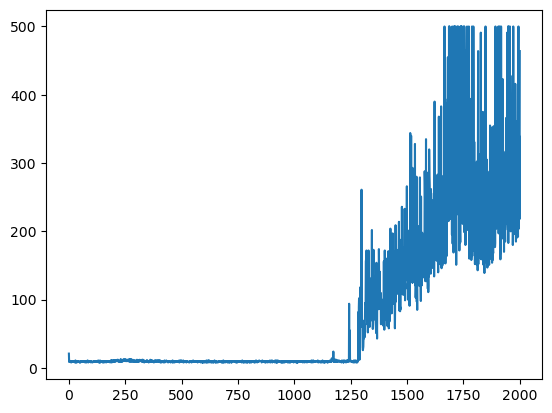

In [9]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)

In [ ]:
print(cumulative_reward[-1-100:])

In [ ]:
plt.plot(rb["next", "step_count"][rb["next", "done"]])

In [ ]:
print(max(cumulative_reward))

In [11]:
record_env.rollout(max_steps=1000, policy=policy)
video_recorder.dump()